# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
# Downloading nltk data
nltk.download(['punkt','stopwords','wordnet'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tati\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tati\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
# Number of recorded interactions
df.shape[0]

45993

In [5]:
# Number of articles
df_content.shape[0]

1056

In [6]:
# Calculating articles per user
articles_per_user = df.groupby('email').count()['article_id']

# Mean articles/user
mean_articles_user = articles_per_user.mean()

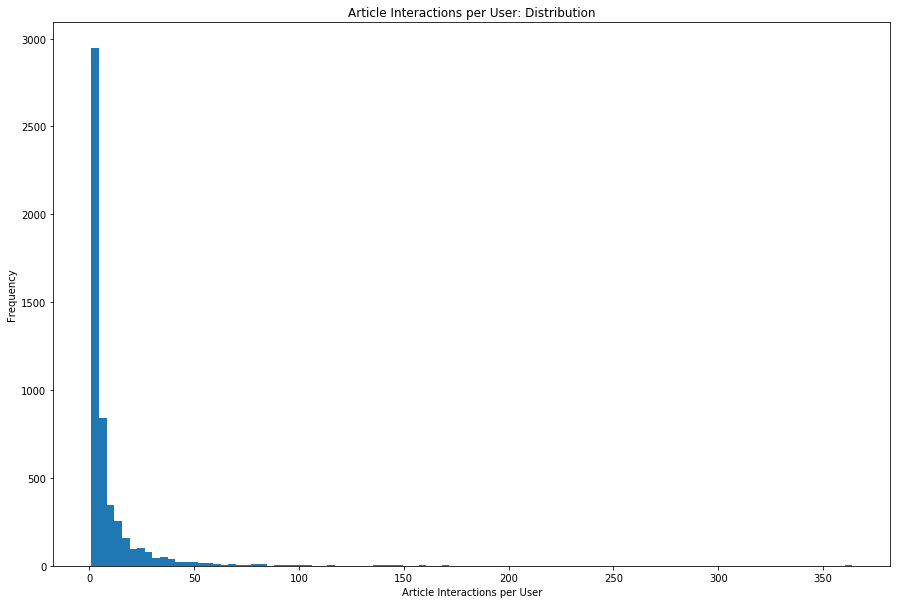

In [7]:
# Visualizing the data: Article Interactions/User
# The majority of users interacted with less than 50 articles

plt.figure(figsize=(15,10));
plt.hist(articles_per_user, bins=100);
plt.xlabel('Article Interactions per User');
plt.ylabel('Frequency');
plt.title('Article Interactions per User: Distribution');

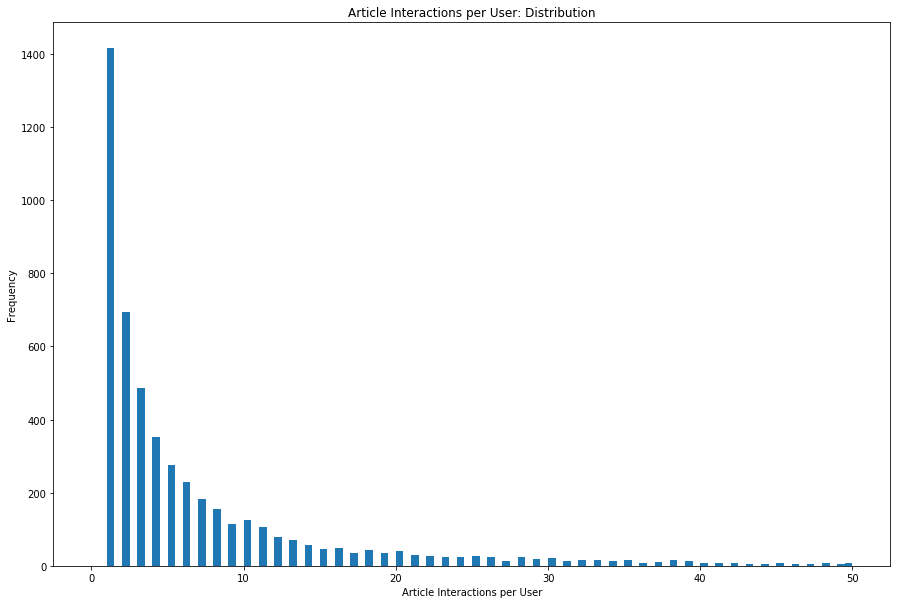

In [8]:
# Visualizing the data: Article Interactions/User
# Zoom-In: up to 50 articles

plt.figure(figsize=(15,10));
plt.hist(articles_per_user, bins=100, range = (0,50));
plt.xlabel('Article Interactions per User');
plt.ylabel('Frequency');
plt.title('Article Interactions per User: Distribution');

In [9]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(articles_per_user) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = articles_per_user.max() # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles

# Creating a df_content version with no duplicates
# Remove any rows that have the same article_id - only keep the first
df_drop_dup = df_content.drop_duplicates(subset ="article_id", keep = 'first')

In [11]:
# Comparing the original content with the no duplicate version
diff_df = pd.merge(df_content, df_drop_dup, how='outer', indicator='Exist')
diff_df = diff_df.loc[diff_df['Exist'] != 'both']

In [12]:
# Visualizing duplicates - they seen to have some differences in the description and body
# but are actually the same articles
df_content[df_content['article_id'].isin(diff_df['article_id']) == True].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [13]:
# Caste df with no duplicates to df_content
df_content = df_drop_dup

`Excursus` NaN Values - df_content

In this section, I will analyze NaN values in the df_content dataframe, that is, if there are any missing values in the content data. This will be useful later in the analysis - does missing data influence article interactions?

In [14]:
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [15]:
# Some articles seem not to have a doc_body...
df_content[df_content['doc_body'].isnull()==True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
206,NaN,Watch how to convert XML data to CSV format to...,Load XML data into dashDB,Live,206
276,NaN,Love to work in Microsoft Excel? Watch how to ...,Integrate dashDB with Excel,Live,276
484,NaN,See how to evaluate and convert your DDL and S...,Convert IBM Puredata for Analytics to dashDB,Live,483
508,NaN,Watch how to generate SQL-based reports for Cl...,Use dashDB with IBM Embeddable Reporting Service,Live,507
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539
638,NaN,See how to create a new dashDB instance and po...,Load JSON from Cloudant database into dashDB,Live,637
667,NaN,"See how to connect dashDB, as a source and tar...",Integrate dashDB and Informatica Cloud,Live,666
706,NaN,Aginity Workbench is a free application known ...,Use Aginity Workbench for IBM dashDB,Live,704
842,NaN,Learn how to configure a dashDB connection in ...,Leverage dashDB in Cognos Business Intelligence,Live,839
876,NaN,See how to populate data into a table in your ...,Load data from the desktop into dashDB,Live,873


In [16]:
# while others do not offer an description
df_content[df_content['doc_description'].isnull()==True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
354,The search index lets you create flexible quer...,NaN,Build the search index in Cloudant,Live,354
768,Compose The Compose logo Articles Sign in Free...,NaN,Announcing the Data Browser for JanusGraph,Live,765
919,Cloudant Query is a powerful declarative JSON ...,NaN,Use the new Cloudant query,Live,916


`Excursus` NaN Values - df

In this section, I will analyze NaN values in the df dataframe, that is, if there are any missing values in the interaction data.

In [17]:
# Some email addresses are missing
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [18]:
# Interactions with no user identification
# To match the expected results, I won't delete the NaN values
df[df['email'].isnull() == True]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [19]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'][df['email'].isnull() == False].nunique() 
# The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique() 
# The number of unique users
unique_users = df['email'].dropna().nunique()
# The number of user-article interactions (with Nan)
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [20]:
# The most viewed article in the dataset was viewed how many times?
max_views = df.groupby('article_id').count()['email'].max()
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.groupby('article_id').count()['email'].sort_values(ascending=False).index[0])

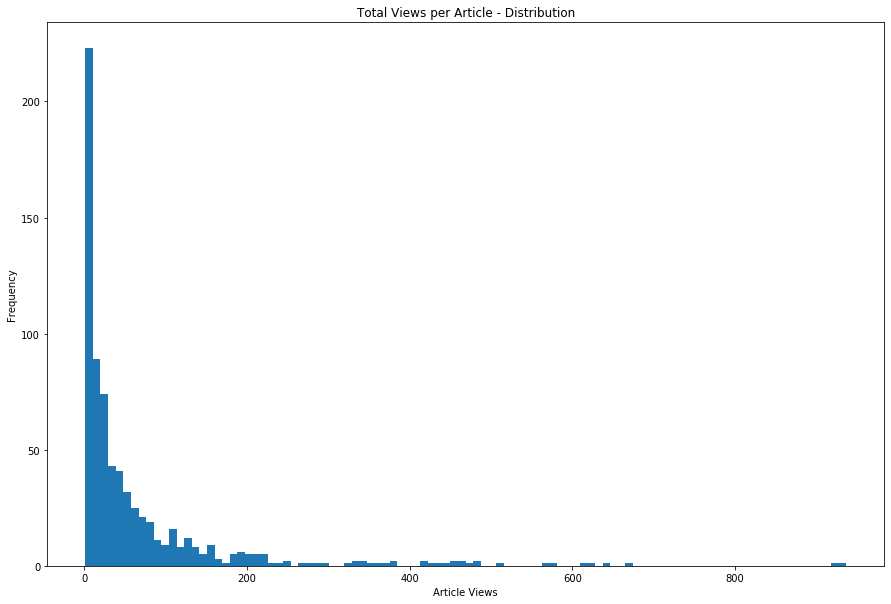

In [21]:
# Visualizing data: Number of views per article
views_per_article = df.groupby('article_id').count()['email']
plt.figure(figsize=(15,10));
plt.hist(views_per_article, bins=100);
plt.xlabel('Article Views');
plt.ylabel('Frequency');
plt.title('Total Views per Article - Distribution');

In [22]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [23]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [24]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = list(df.groupby('title').count()['user_id'].sort_values(ascending=False).index)[0:n] 
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('article_id').count()['user_id'].sort_values(ascending=False).index)[0:n]
 
    return top_articles # Return the top article ids

In [25]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [26]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [27]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    df_user_item = df.copy()
    df_user_item['zero_one'] = np.ones(df_user_item.shape[0]) # helping column to store interactions
    user_item = df_user_item.groupby(['user_id', 'article_id'])['zero_one'].max().unstack().fillna(0)
   
    return user_item 

user_item = create_user_item_matrix(df)

In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    sim_user = np.dot(user_item[user_item.index == user_id], user_item.transpose())

    # sort by similarity
    sim_df = pd.DataFrame(sim_user.transpose(), index = user_item.index)
    sim_df = sim_df.sort_values(0, ascending=False)

    # create list of just the ids
    most_similar_users = list(sim_df.index)

    # remove the own user's id
    most_similar_users = [user for user in most_similar_users if user != user_id]
       
    return most_similar_users # return a list of the users in order from most to least similar

In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [31]:
# To get the tests right, we have to convert the article_id column into string
df['article_id'] = df['article_id'].astype(str)

In [42]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = list(df[df['article_id'].isin(article_ids) == True]['title'].unique())    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = list(df[df['user_id'] == user_id]['article_id'].unique())
    article_names = get_article_names(article_ids)    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get articles seen by user
    seen_art_ids, seen_art_names = get_user_articles(user_id)
    # Get similar users
    similar_users = find_similar_users(user_id)
    recs = []
    
    # Loop through similar users
    for user in similar_users:
        if len(recs) > m:
            break
        else:
            # find articles read by similar user
            new_art_ids, new_art_names = get_user_articles(user)
            for _id in new_art_ids:
                # if new, append to recs
                if _id not in seen_art_ids:
                    recs.append(_id)
                    if len(recs) > m:
                        break
                    
    return recs  

In [43]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [44]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Calculating similarity to user_id
    sim_user = np.dot(user_item[user_item.index == user_id], user_item.transpose())
    
    # Converting to df
    sim_df = pd.DataFrame(sim_user.transpose(), index = user_item.index, columns = ['similarity'])
    
    # Calculating user interactions
    user_interact =  df.groupby('user_id').count()['title'].rename('num_interactions')
    
    # Concatenating and sorting 
    neighbors_df = (pd.concat([sim_df, user_interact], axis=1)
                    .sort_values(by=['similarity', 'num_interactions'], ascending=False))
    
    # Renaming index
    neighbors_df.index.name = 'neighbor_id'
    
    # Deleting row with user_id
    neighbors_df = neighbors_df[neighbors_df.index != user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    df - (pandas dataframe) df as defined at the top of the notebook 
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Storing articles seen by user
    seen_art_ids, seen_art_names = get_user_articles(user_id)
    # Get similar users
    similar_users = list(get_top_sorted_users(user_id).index)
    # Get articles ordered by view count
    inter = df.groupby('article_id').count()['title'].sort_values(ascending=False)
    recs = []
    
    # loop through similar users
    for user in similar_users:
        if len(recs) > m:
            break
        else:
            # get articles read by similar user
            new_art_ids = get_user_articles(user)[0]
            # sort those articles by number of views
            order_new_art = list(inter[inter.index.isin(new_art_ids)].index)
            for _id in order_new_art:
                # if new, append to recs
                if _id not in seen_art_ids:
                    recs.append(_id)
                    if len(recs) > m:
                        break

    # get articles' names
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [45]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0', '1338.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [46]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index[9] # Find the 10th most similar user to user 131

In [47]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

So far we have used Rank-based Recommendations and User-User-based Collaborative Filtering:
* **Rank-based:** we sort the articles by popularity (i.e., by the amount of interactions), and recommend the most popular ones to any user. This method caters for new users; however, it is too generic and does not take any user preferences into account. 
* **User-User-based:** our database contains multiple users and their interactions. We find similar users based on the articles they have read, and recommend new items that similar users have interacted with. As new users are not in our database, it is impossible to calculate their similarity to the existing users - we are facing a cold-start problem!

In my opinion, we could do better than the rank-based approach with the help of a knowlegde based filtering. Many websites (e.g. Pinterest, The New York Times) require "preferences" information from new users - that is, which topics interest you the most. 

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [48]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Rank Based Recommendation

new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [49]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [40]:
def tokenize(text):
    '''
    INPUT:
    text - (str) to be normalized, tokenized, have its stopwords removed, and
            be lemmatized
    
    OUTPUT:
    tokens - (list) with processed tokens
    
    Description:
    This function reduces the complexity of a given text by normalizing it,
    removing its punctuation, trailing spaces and stop words, and by lemmatizing
    its verbs and nouns.
    '''
    #normalize and remove punctuation
    text = text.lower()
    text = re.sub(r"\W", " ", text)
    # tokenize
    tokens = word_tokenize(text)
    # remove stop words
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    # lemmatize nouns
    tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens]
    # lemmatize verbs
    tokens = [WordNetLemmatizer().lemmatize(w, pos = 'v') for w in tokens]
    # remove trailing space
    tokens = list(map(str.strip, tokens))
    return tokens

Most frequent words in title:
0        data
1         ibm
2         use
3       learn
4     science
5      watson
6     compose
7    cloudant
8         lab
9       spark
Name: words, dtype: object


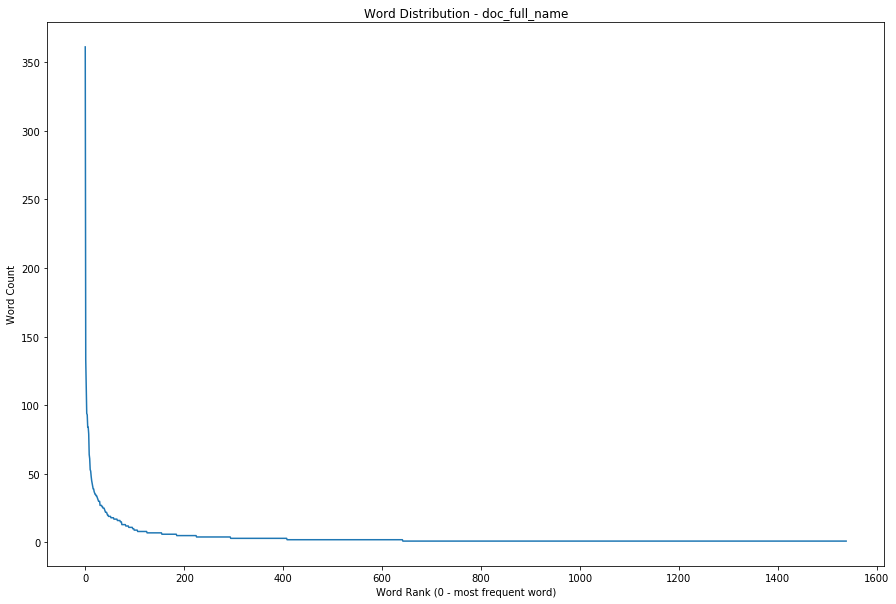

In [41]:
def visualize_word_freq_titles(df_content=df_content):
    '''
    INPUT:
    df_content - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    prints out the most frequent words of the articles' titles and the word distribution
    
    '''
    
    # Initialize a count vectorizer (sklearn) with the tokenize function defined above
    vect = CountVectorizer(tokenizer=tokenize)
    
    # Fit Transform with our data - the doc_full_names from df_content
    # word_freq's rows represent each title ("document")
    # word_freq's columns represent the words in each title ("vocabulary")
    word_freq = vect.fit_transform(df_content['doc_full_name'])
    
    # Creating data frame with words and their frequency
    word_list = vect.get_feature_names();    
    count_list = word_freq.toarray().sum(axis=0)
    df_word_freq = (pd.DataFrame(data={'words': word_list, 'counts': count_list})
                    .sort_values('counts', ascending = False).reset_index(drop = True))
    
    # Print top 10 most frequent words
    print('Most frequent words in title:')
    print(df_word_freq['words'][0:10])
    
    # Visualizing word frequency
    plt.figure(figsize=(15,10));
    plt.plot(df_word_freq.index, df_word_freq['counts']);
    plt.xlabel('Word Rank (0 - most frequent word)');
    plt.ylabel('Word Count');
    plt.title('Word Distribution - doc_full_name');
    plt.show
    
visualize_word_freq_titles()

In [50]:
def make_content_recs(article_ids, m=10, df_content=df_content, df=df):
    '''
    INPUT:
    article_ids - (list) the article_ids to be matched with similar articles 
    m - (int) the max number of recommendations you want for each article
    df_content - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    all_recs - (dict) a dictionary containing recommendations (ids) for each given article_id
    
    Description:
    Creates a CountVectorizer with the previously defined tokenizer
    Fits and transforms to all article titles/descriptions/bodies from df_content
    Creates a similarity matrix: similarity between every article duo
    For each article_id - finds most similar articles, until m recommendations are found
    '''
    # Initialize a count vectorizer (sklearn) with the tokenize function defined above
    vect = CountVectorizer(tokenizer=tokenize)
    
    # Remove NaN values in respect to the df content column to be analyzed
    df_npl = df_content.dropna(subset=['doc_full_name'], axis=0)
    
    # Add items if they are not present in df_npl - e.g. new articles
    for _id in article_ids:
        if _id not in df_npl['article_id']:
            if _id in df['article_id']:
                # Retrieve data from df dataframe
                new_title = df[df['article_id']==str(float(_id))]['title'].unique()[0]
                to_append = pd.DataFrame({"doc_full_name":[new_title], 
                                            "article_id":[_id]}) 
                df_npl = df_npl.append(to_append, ignore_index = True) 

            else:
                print('Sorry, we do not have any information about this article!')
                return
    
    # Fit Transform with our data - the titles from df_content
    # word_freq's rows represent each title/description/body ("document")
    # word_freq's columns represent the words in each title/description/body  ("vocabulary")   
    word_freq = vect.fit_transform(df_npl['doc_full_name'])
    
    # Creating similarity matrix
    sim_content = word_freq.dot(np.transpose(word_freq))
    
    # Transforming matrix in a dataframe
    df_sim = pd.DataFrame(sim_content.toarray(), index = df_npl['article_id'], columns = df_npl['article_id'])
    
    # Initializing dict for recommendations
    all_recs = {}
    
    for _id in article_ids:
        # Initialize recommendations list
        recs = []
        # Select the similarity df row that corresponds to this _id, and sort its values
        order_sim = df_sim[df_sim.index == _id].transpose().sort_values(_id, ascending = False)
        # Remove articles with no similarity (0) and the current article_id
        clean_sim = order_sim[(order_sim[_id]!=0) & (order_sim.index != _id)]
        # Select most similar articles 
        most_sim = clean_sim[clean_sim[_id]==clean_sim[_id].max()]
        # Append similar article_ids to recs
        for article in list(most_sim.index):
            recs.append(article)
            if len(recs) > m:
                break
        all_recs[_id] = recs
            
    return all_recs

In [51]:
# Performing some tests...

make_content_recs([1, 2, 3, 4])

{1: [349, 21, 1025, 1042, 685, 363, 634, 1014, 168],
 2: [448, 559, 348],
 3: [664, 548],
 4: [958, 486, 100]}

In [52]:
# Checking "similar" titles (1)
# Good example - all titles contain "Data Science"
df_content[df_content['article_id'].isin([1, 349, 21, 1025, 1042, 685, 363, 634, 1014, 168]) == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
21,Raj Singh Blocked Unblock Follow Following Dev...,You’re doing your data a disservice if you don...,Mapping for Data Science with PixieDust and Ma...,Live,21
168,Glynn Bird Blocked Unblock Follow Following De...,Python and Node.js in the same Jupyter noteboo...,Node.js data science notebooks – IBM Watson Da...,Live,168
349,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,"This white paper introduces SparkR, a package ...",IBM Data Science Experience White paper - Spar...,Live,349
363,Homepage IBM Watson Follow Sign in Get started...,The following information will help IBM Bluemi...,Migration from IBM Bluemix Data Connect API (a...,Live,363
635,Homepage Follow Sign in / Sign up Homepage * H...,Because it is optimized for analytic operation...,Working with Db2 Warehouse on Cloud in Data Sc...,Live,634
686,Homepage IBM Watson Follow Sign in Get started...,IBM Watson offers a collection of REST APIs f...,Working with data flows using Watson Data APIs,Live,685
1019,Follow Sign in / Sign up * Home\r\n * Dev\r\n ...,"A year ago, I dropped out of one of the best c...",I ranked every Intro to Data Science course on...,Live,1014
1030,Homepage Follow Sign in / Sign up Homepage * H...,"Since then, this metric has been ubiquitously ...",Data tidying in Data Science Experience,Live,1025
1047,Homepage Follow Sign in / Sign up Homepage * H...,"In this post, we will go through how to read a...",Use IBM Data Science Experience to Read and Wr...,Live,1042


In [53]:
# Checking "similar" titles (2)
# Good Example - all articles contains "This Week in Data Science"
df_content[df_content['article_id'].isin([2, 448, 559, 348]) == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
348,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 25, 2017)",Live,348
449,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 11, 2017)",Live,448
560,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 4, 2017)",Live,559


In [54]:
# Checking "similar" titles (3)
# Good Example - all articles contain "DataLayer Conference"
df_content[df_content['article_id'].isin([3, 664, 548]) == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
549,Compose Databases * MongoDB\r\n * Elasticsearc...,Video from Compose's DataLayer conference.,"DataLayer Conference: Scylla, the High-Perform...",Live,548
665,DATALAYER: PARTIAL INDEXING FOR IMPROVED QUERY...,Chris Erwin shares his experience with partial...,DataLayer Conference: Partial Indexing for Imp...,Live,664


In [55]:
# Checking "similar" titles (4)
# This Example is not so good - the words "use", "analyze" and "data" appear,
# but the articles seem unrelated
df_content[df_content['article_id'].isin([4, 958, 486, 100]) == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
100,Skip navigation Sign in SearchLoading...\r\n\r...,This video shows you how to add a data asset t...,Use data assets in a project using IBM Data Ca...,Live,100
487,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,SparkR provides a distributed data frame API t...,Use Spark R to Load and Analyze Data,Live,486
961,Homepage Follow Sign in Get started * Home\r\n...,DSX offers a wealth of functionality to any so...,Using DSX notebooks to analyze GitHub data,Live,958


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here.**

My content-based recommendation uses the ``doc_full_name`` column, that is, it uses the articles' titles as a measure of similarity.

I have written a function ``tokenize``, which reduces the complexity of the texts by normalizing them, removing their punctuation, trailing spaces and stop words, and by lemmatizing their verbs and nouns. 

In the function called ``make_content_recs``, I use ``tokenize`` to instanciate and fit a ``CountVectorizer`` object, which counts the frequency of each token (i.e., processed word) in the given documents (e.g., titles). 

The fitted and transformed ``CountVectorizer`` is then used to obtain a content-similarity matrix, called ``sim_content``, obtained by the dot product of the ``CountVectorizer`` matrix and its transposed matrix.

The ``df_sim`` matrix is a square matrix, where rows and columns receive the article_id, and the values ``df_sim[i][j]`` correspond to the similarity between article i (row) and j (column). 

Using ``df_sim``, we can find which articles are the most similar to a certain article, by finding the highest number on its corresponding row. Articles with the highest similarity are returned by the function.

We can use this function to provide recommendations based on the articles that the user has already read.

Some drawbacks: this approach does not work very well when using the ``doc_body`` and ``doc_description`` criteria. The longer the text, higher the probability of obtaining an irrelevant similarity. 

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [56]:
# make a recommendations for a user who only has interacted with article id '1427.0'
recs = make_content_recs([1427])

# checking recommendations - seem to be driven by words 'learn, machine, learning'
print('Original Article Name: ', get_article_names(['1427.0'])[0])
for item in df_content[df_content['article_id'].isin(recs[1427])]['doc_full_name']:
    print ('Recommended Article Name: ',item)

Original Article Name:  use xgboost, scikit-learn & ibm watson machine learning apis
Recommended Article Name:  Python Machine Learning: Scikit-Learn Tutorial
Recommended Article Name:  From Machine Learning to Learning Machine (Dinesh Nirmal)


In [57]:
# make recommendations for a brand new user
# I will recommend the most similar articles to the most viewed article 
most_viewed = int(float(most_viewed_article_id))
recs = make_content_recs([most_viewed])

# checking recommendations - seem to be driven by 'deep learning, use, learn'
print('Most Popular Article Name: ', get_article_names([most_viewed_article_id])[0])
for item in df_content[df_content['article_id'].isin(recs[most_viewed])]['doc_full_name']:
    print ('Recommended Article Name: ',item)

Most Popular Article Name:  use deep learning for image classification
Recommended Article Name:  Learn TensorFlow and Deep Learning Together and Now!
Recommended Article Name:  Using BigDL in DSX for Deep Learning on Spark
Recommended Article Name:  Using Deep Learning With Keras To Predict Customer Churn
Recommended Article Name:  The Difference Between AI, Machine Learning, and Deep Learning?
Recommended Article Name:  Using Deep Learning to Reconstruct High-Resolution Audio


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [58]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [59]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [60]:
# No NaNs in the user_item_matrix - we can use numpy's SVD directly
np.count_nonzero(np.isnan(user_item_matrix))

0

In [61]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

**Provide your response here.**

The current user_item_matrix does not have, per definition, any missing values. From Part III, Question 1:

* If a user has not interacted with an item, then place a **zero** where the user-row meets for that article-column.

In the lesson, the lack of interaction was represented by a missing value, as the user_item_matrix values were actually ratings. If the user did not interact with an item, we do not have a rating - thus the nan. 

Here, however, we just want to represent whether the interaction took place (1) or not (0). The absence of missing values allows us to use numpy's SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

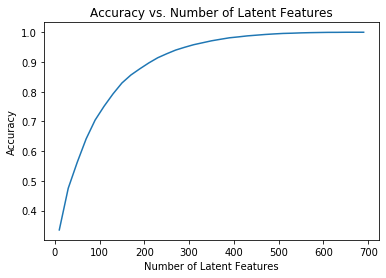

In [62]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [63]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create user_item_matrix for training data
    user_item_train = create_user_item_matrix(df_train)
    # sorting columns
    user_item_train = user_item_train.sort_index(axis=1)
    
    # create user_item_matrix for testing data
    user_item_test = create_user_item_matrix(df_test)
    # sorting columns
    user_item_test = user_item_test.sort_index(axis=1)
    
    # test user and article ids 
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [64]:
# Identifying cold start problem: USERS
# Users in the training set
train_idx = list(user_item_train.index)
# Users in the test set, but not in training
test_not_train = [x for x in test_idx if x not in train_idx]
print('{} users have the cold start problem.'.format(len(test_not_train)))
print('We will be able to make predictions for {} users from the test set.'.format(len(test_idx) - len(test_not_train)))

662 users have the cold start problem.
We will be able to make predictions for 20 users from the test set.


In [65]:
# Identifying cold start problem: ARTICLES
# Users in the training set
train_arts = list(user_item_train.columns)
# Users in the test set, but not in training
test_not_train = [x for x in test_arts if x not in train_arts]
print('{} articles have the cold start problem.'.format(len(test_not_train)))
print('We will be able to make predictions for {} articles from the test set.'.format(len(test_arts) - len(test_not_train)))

0 articles have the cold start problem.
We will be able to make predictions for 574 articles from the test set.


In [66]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [67]:
# find users and articles from test data that can be predicted with train data
user_pred = [x for x in test_idx if x in train_idx]
arts_pred = test_arts

In [68]:
# fit SVD on the user_item_train matrix
# with articles present in the test set
u_train, s_train, vt_train = np.linalg.svd(user_item_train[arts_pred], full_matrices=False)

In [69]:
# Reshaping matrices
s_new, u_new, vt_new = np.diag(s_train), u_train, vt_train

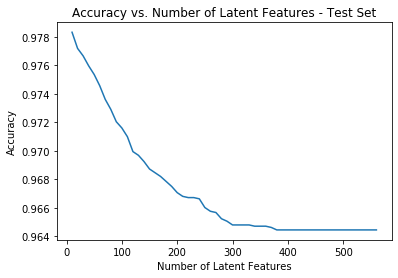

In [70]:
# Measuring accuracy on the test set
num_latent_feats = np.arange(10,570,10)
sum_errs_total = []

for k in num_latent_feats:
    # list of errors for each user in user_pred
    sum_errs = []
    
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # for each user in "predictable" test set
    for user in user_pred:
        # get its predictions from user_item_est
        pred_user = user_item_est[train_idx.index(user)]
        # get actual values from user_item_test
        actual_values = np.array(user_item_test[user_item_test.index == user])
        # calculate difference
        diffs = np.subtract(actual_values, pred_user)
        # total error for this user
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)
        
    # sum all errors for user_pred and track
    sum_errs_total.append(np.sum(sum_errs))

# plot accuracy
plt.plot(num_latent_feats, 1 - np.array(sum_errs_total)/(len(user_pred)*len(arts_pred)));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features - Test Set');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Only 20 users from the test set were present in the training data, so we do not have enough data to analyze the performance of this recommendation engine. The high accuracy, however, is due to the imbalance of the testing set (see calculation below): a small percentage of (user, article) pairs have had actual interactions on the test set. Measures like recall and precision will tell another story about the model's performance!

Also interesting is the reduced accuracy with a higher number of latent features - maybe there is some overfitting to the train data when using all possible latent factors.

In [89]:
test_interactions = user_item_test[user_item_test.index.isin(user_pred)].sum().sum()
test_pairs = user_item_test[user_item_test.index.isin(user_pred)].shape[0]*user_item_test[user_item_test.index.isin(user_pred)].shape[1]
test_percentage = 100*test_interactions/test_pairs
print('{:.1f}% of the pairs on the test set had actual interactions. The dataset is heavily imbalanced!'.format(test_percentage))

1.9% of the pairs on the test set had actual interactions. The dataset is heavily imbalanced!


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [90]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0